### BDP Final Project: Twitter Credibility Analysis on Special Education - Part 4: Timeline Analysis

In [1]:
spark.version

'3.1.3'

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# import pycountry
# import pycountry_convert as pc
from pyspark.sql.functions import to_timestamp

import matplotlib.pyplot as plt
import plotly.express as px
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')

import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')

from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan,when,count
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

In [3]:
# List all files in given COS directory
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns=['Name','Size'])

    blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [4]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
time_df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_date_format')

In [6]:
time_df.limit(2)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet,tweet_created_week_day,tweet_created_month,tweet_created_day,tweet_created_time,tweet_created_year,account_created_week_day,account_created_month,account_created_day,account_created_time,account_created_year,tweet_created_month_num,account_created_month_num,tweet_created_date,account_created_date
1514974123751088133,0,Fri Apr 15 14:29:...,0,en,join us 4/25 for ...,1189250547355811840,MIT.nano,We measure the fu...,1522,1501,false,Tue Oct 29 18:40:...,null,null,null,false,null,null,null,null,null,null,null,true,Fri,Apr,15,14:29:12,2022,Tue,Oct,29,18:40:06,2019,04,10,2022-04-15,2019-10-29
1514974131434971140,0,Fri Apr 15 14:29:...,0,en,a teacher for mor...,819662390149214208,dan marshall,Ontario correctio...,243,11515,false,Thu Jan 12 21:48:...,null,null,null,true,EAlexander46,231,54,9,[],1351258907113648128,1514954830141399040,false,Fri,Apr,15,14:29:14,2022,Thu,Jan,12,21:48:37,2017,04,01,2022-04-15,2017-01-12


In [7]:
time_df.count()

33490185

In [8]:
time_df.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- tweet_likes: long (nullable = true)
 |-- time_tweet_created: string (nullable = true)
 |-- tweet_reply_count: long (nullable = true)
 |-- language: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_followers_count: long (nullable = true)
 |-- user_like_count: long (nullable = true)
 |-- verified_user: boolean (nullable = true)
 |-- time_account_created: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- is_retweeted: boolean (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- rt_likes: long (nullable = true)
 |-- rt_count: long (nullable = true)
 |-- rt_reply_count: long (nullable = true)
 |-- rt_hashtags: array (nullable = true)
 |    |-- element: string (containsNu

####  **4. What are the timelines of these tweets? Do you see significant peaks and valleys?**

##### **Do you see any data collection gaps?**

In [9]:
time_df = time_df.select(['tweet_id', 'tweet_created_week_day','tweet_created_month', 'tweet_created_day', 'tweet_created_time', 'tweet_created_year',\
                          'tweet_created_date', 'account_created_week_day', 'account_created_month', 'account_created_day', 'account_created_time', 'account_created_year',\
                          'account_created_date'])

In [13]:
# convert month to standard MM
time_df = time_df.withColumn('tweet_created_month_num', from_unixtime(unix_timestamp(col('tweet_created_month'), 'MMM'), 'MM'))
time_df = time_df.withColumn('account_created_month_num', from_unixtime(unix_timestamp(col('account_created_month'), 'MMM'), 'MM'))

In [14]:
# merge the YYYY-MM
time_df = time_df.withColumn('tweet_created_date_merge', concat_ws('-', 'tweet_created_year', 'tweet_created_month_num')) \
           .withColumn('tweet_created_ym', to_date('tweet_created_date_merge', 'yyyy-MM')) \
           .withColumn('account_created_date_merge', concat_ws('-', 'account_created_year', 'account_created_month_num')) \
           .withColumn('account_created_ym', to_date('account_created_date_merge', 'yyyy-MM')) \
           .drop('tweet_created_date_merge') \
           .drop('account_created_date_merge')

In [15]:
time_df.limit(2)

tweet_id,tweet_created_week_day,tweet_created_month,tweet_created_day,tweet_created_time,tweet_created_year,tweet_created_date,account_created_week_day,account_created_month,account_created_day,account_created_time,account_created_year,account_created_date,tweet_created_month_num,account_created_month_num,tweet_created_ym,account_created_ym
1514974123751088133,Fri,Apr,15,14:29:12,2022,2022-04-15,Tue,Oct,29,18:40:06,2019,2019-10-29,04,10,2022-04-01,2019-10-01
1514974131434971140,Fri,Apr,15,14:29:14,2022,2022-04-15,Thu,Jan,12,21:48:37,2017,2017-01-12,04,01,2022-04-01,2017-01-01


In [16]:
overall_time_df = time_df.groupBy(['tweet_id', 'tweet_created_date']).count().orderBy('count', ascending=False)

In [17]:
type(overall_time_df)

pyspark.sql.dataframe.DataFrame

In [ ]:
overall_time_df.count()

In [ ]:
overall_time_df.limit(5)

In [18]:
overall_time_pd = overall_time_df.limit(100000).toPandas()

In [19]:
overall_time_pd

,tweet_id,tweet_created_date,count
0,1524648307431251970,2022-05-12,15
1,1524648253840670720,2022-05-12,9
2,1557798923204382720,2022-08-11,8
3,1524648350402105345,2022-05-12,7
4,1524648406060347392,2022-05-12,6
...,...,...,...
99995,1511391057908359169,2022-04-05,1
99996,1568341326823067650,2022-09-09,1
99997,1568341764792061952,2022-09-09,1
99998,1517560577492717568,2022-04-22,1


##### **Plot the timelines of these tweets**

- overall

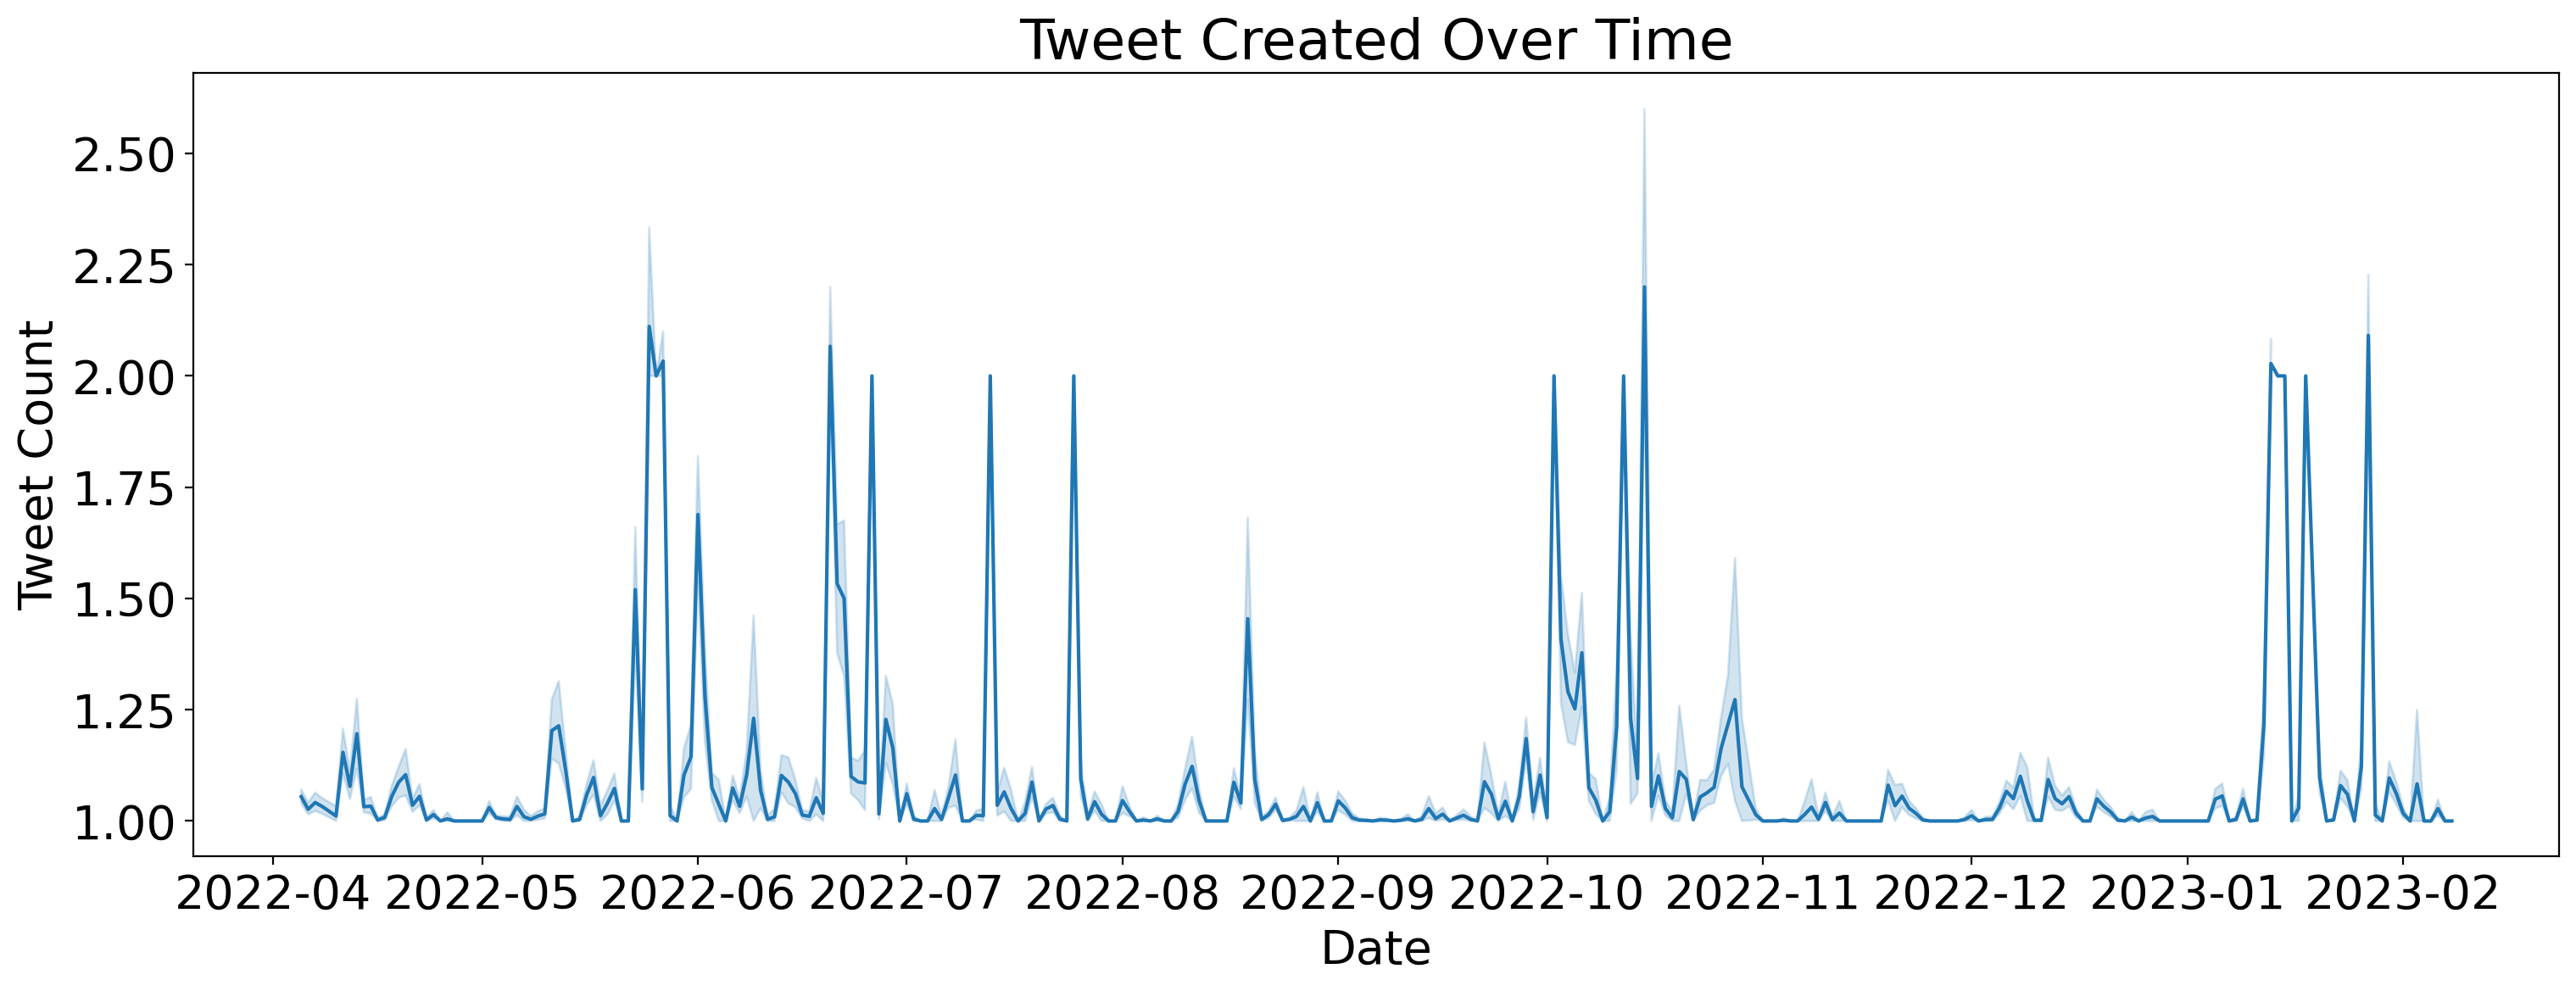

In [20]:
plt.rcParams["figure.figsize"] = (18,6)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 20})

sns.lineplot(data= overall_time_pd, x='tweet_created_date', y='count')
plt.title('Tweet Created Over Time')
plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.show()

In [ ]:
sns.set_style('whitegrid')

ax = sns.lineplot(data= overall_time_pd, x='tweet_created_date', y='count')
ax.set(title='Tweet Created Over Time', xlabel='Date', ylabel='Tweet Count')
plt.xticks(rotation=90) # rotate the x-axis labels by 45 degrees
plt.show()

In [ ]:
sns.lineplot(data= overall_time_pd, y='tweet_created_date', x='count')
plt.title('Tweet Created Over Time')
plt.ylabel('Date')
plt.xlabel('Tweet Count')
plt.show()

In [ ]:
sns.histplot(data=overall_time_pd, x='tweet_created_date', bins=50)
plt.title('Tweet Created Over Time')
plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.show()

In [ ]:
ax = overall_time_pd.plot(kind = 'line', x = 'tweet_created_date', y = 'count', color='darkblue')
ax.set_xlabel('Date')
ax.set_ylabel('Total Tweet Count')
ax.set_title('Tweet Created Over Time')

In [ ]:
plt.plot(overall_time_pd['count'], overall_time_pd['tweet_created_date'])
plt.title('Tweet Created Over Time')
plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.show()

- year & month

In [ ]:
tweet_ym = time_df.groupBy(['tweet_id', 'tweet_created_ym']).count().orderBy('count', ascending=False)

In [ ]:
tweet_ym_pd = tweet_month.toPandas()

In [ ]:
sns.lineplot(data= tweet_ym_pd, x='tweet_created_day', y='count')
plt.title('Tweet Created Over Time')
plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.show()

In [ ]:
# overall_time_df = time_df.groupBy(['tweet_id', 'tweet_created_date']).count().orderBy('count', ascending=False)

In [ ]:
# type(time_df)

In [ ]:
# time = overall_time_df.rdd.map(lambda x: (x.tweet_created_date, x.count)).collect()
# pandas_df = pd.DataFrame(data, columns=['tweet_created_date', 'count'])

# plt.plot(pandas_df['tweet_created_date'], pandas_df['count'])
# plt.title('Sales over the years')
# plt.xlabel('Year')
# plt.ylabel('Sales')
# plt.show()

In [ ]:
# time = overall_time_df.rdd.map(lambda x: (x.tweet_created_date, x.count)).collect()
# pandas_df = pd.DataFrame(data, columns=['tweet_created_date', 'count'])

# plt.plot(pandas_df['tweet_created_date'], pandas_df['count'])
# plt.title('Tweet Created Over Time')
# plt.xlabel('Date')
# plt.ylabel('Tweet Count')
# plt.show()

- By organization

In [21]:
org_time_df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_time_change')

In [23]:
org_time_df.limit(2)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet,twitterer_catogory,tweet_created_week_day,tweet_created_month,tweet_created_day,tweet_created_time,tweet_created_year,account_created_week_day,account_created_month,account_created_day,account_created_time,account_created_year,tweet_created_month_num,account_created_month_num,tweet_created_date,account_created_date
1514974123751088133,0,Fri Apr 15 14:29:...,0,en,join us 4/25 for ...,1189250547355811840,mit.nano,we measure the fu...,1522,1501,false,Tue Oct 29 18:40:...,null,null,null,false,null,null,null,null,null,null,null,true,other,Fri,Apr,15,14:29:12,2022,Tue,Oct,29,18:40:06,2019,04,10,2022-04-15,2019-10-29
1514974131434971140,0,Fri Apr 15 14:29:...,0,en,a teacher for mor...,819662390149214208,dan marshall,ontario correctio...,243,11515,false,Thu Jan 12 21:48:...,null,null,null,true,EAlexander46,231,54,9,[],1351258907113648128,1514954830141399040,false,other,Fri,Apr,15,14:29:14,2022,Thu,Jan,12,21:48:37,2017,04,01,2022-04-15,2017-01-12


In [25]:
org_time_df = org_time_df.select(['tweet_id', 'tweet_created_week_day','tweet_created_month', 'tweet_created_day', 'tweet_created_time', 'tweet_created_year',\
                          'tweet_created_date', 'account_created_week_day', 'account_created_month', 'account_created_day', 'account_created_time', 'account_created_year',\
                          'account_created_date', 'twitterer_catogory'])

In [26]:
org_time_df2 = org_time_df.groupby(['twitterer_catogory','tweet_created_date']).count().orderBy('count', ascending=False)

In [27]:
org_time_pd = org_time_df2.toPandas()

In [28]:
org_time_pd

,twitterer_catogory,tweet_created_date,count
0,other,2022-08-25,161035
1,other,2022-08-24,131400
2,other,2022-08-26,124860
3,other,2022-04-28,112056
4,other,2022-06-01,111033
...,...,...,...
2165,Influencer,2022-12-23,73
2166,Influencer,2022-12-27,71
2167,Influencer,2023-01-01,67
2168,Influencer,2022-12-26,57


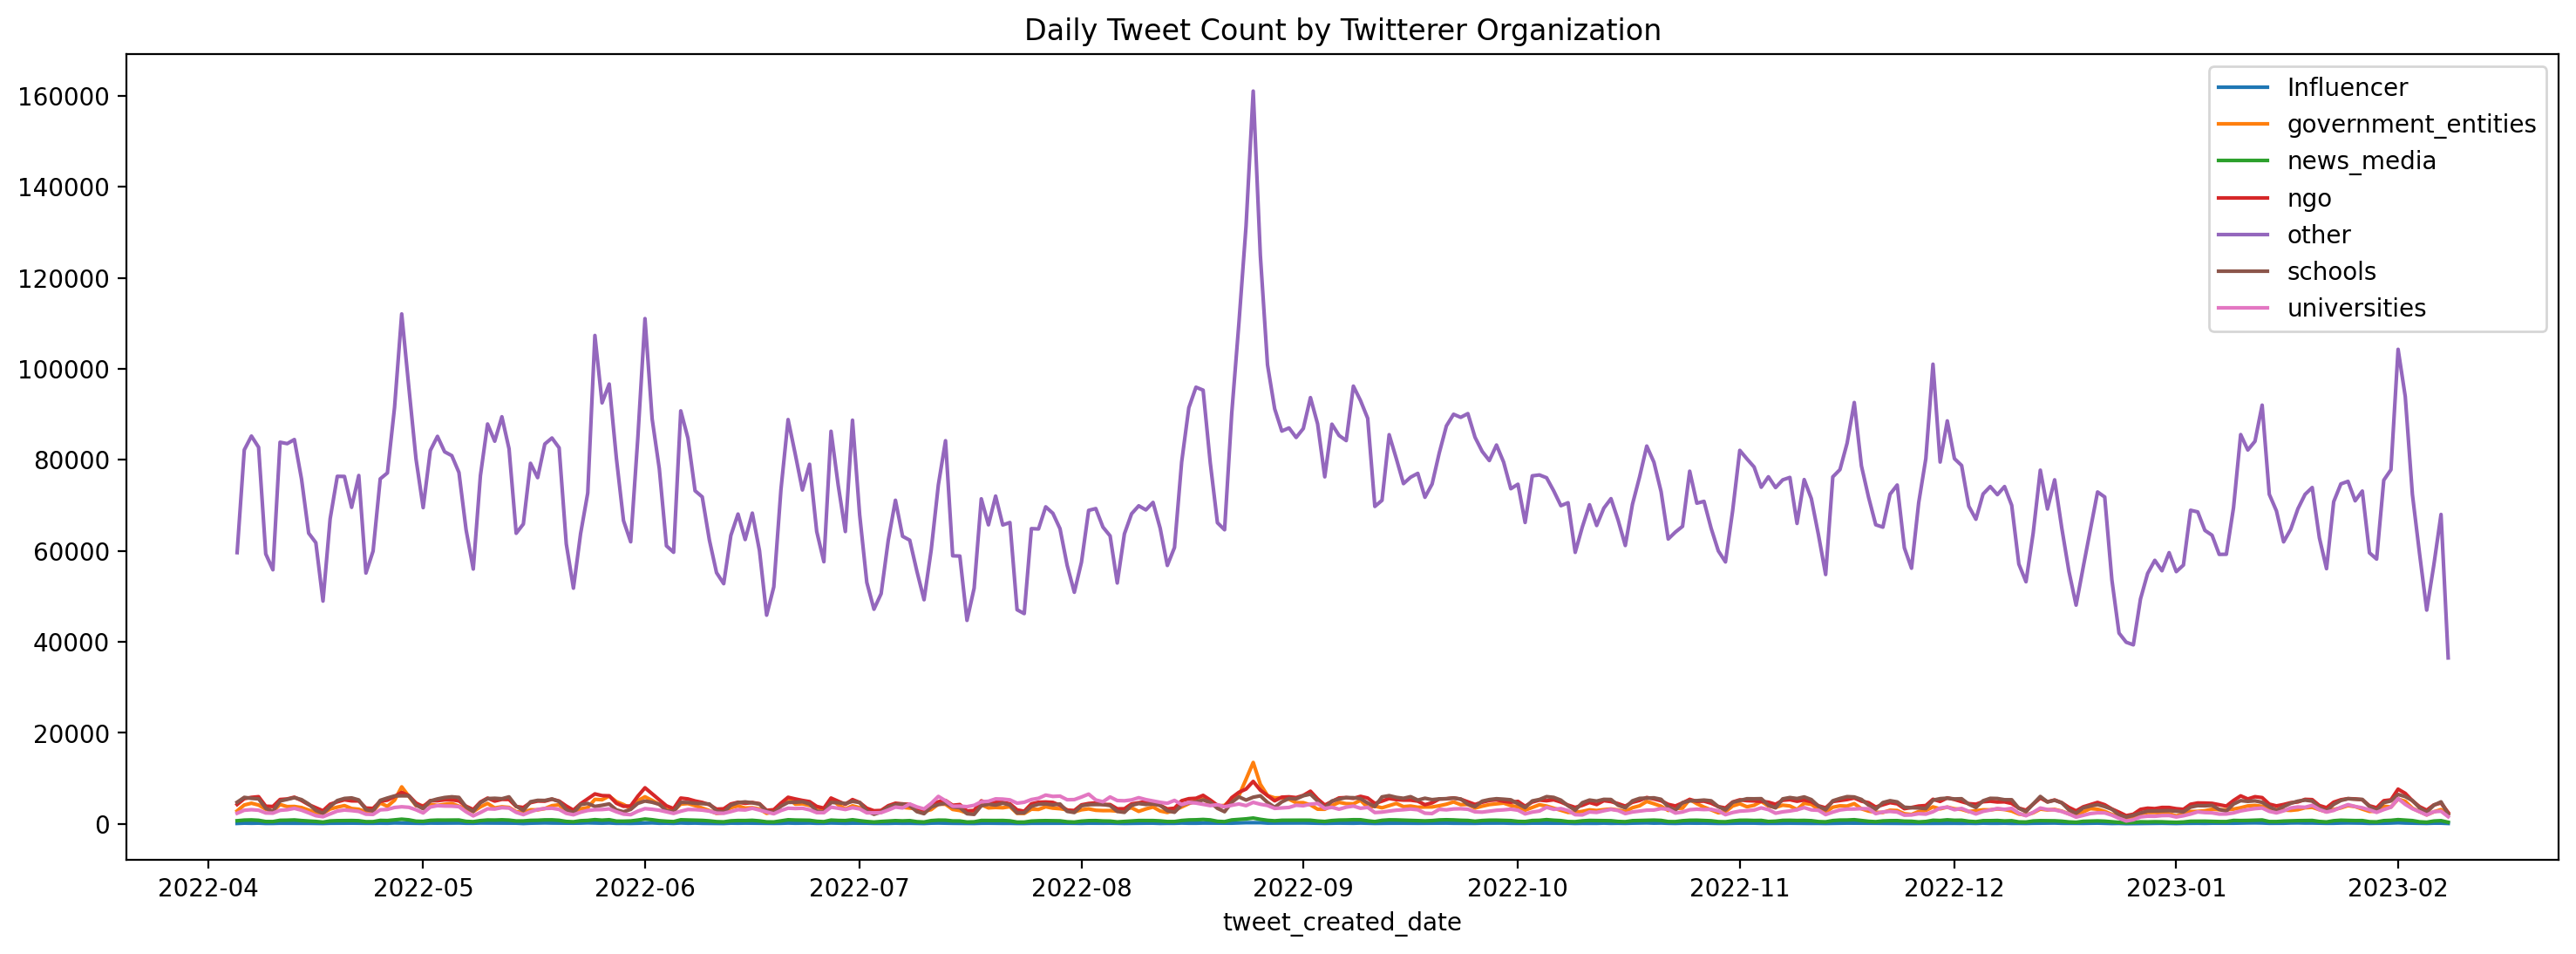

In [31]:
from matplotlib import pyplot as plt 
plt.rcParams.update({'font.size':10})
fig, ax = plt.subplots()
for label, grp in org_time_pd.groupby('twitterer_catogory'):
    grp.plot(x = 'tweet_created_date', y = 'count',ax = ax, label = label,title='Daily Tweet Count by Twitterer Organization')

- Remove other

In [33]:
org_time_pd2 = org_time_pd[org_time_pd['twitterer_catogory'] != 'other']

In [34]:
org_time_pd2

,twitterer_catogory,tweet_created_date,count
310,government_entities,2022-08-25,13476
311,government_entities,2022-08-24,9783
312,ngo,2022-08-25,9313
313,government_entities,2022-08-26,8662
314,government_entities,2022-04-28,8117
...,...,...,...
2165,Influencer,2022-12-23,73
2166,Influencer,2022-12-27,71
2167,Influencer,2023-01-01,67
2168,Influencer,2022-12-26,57


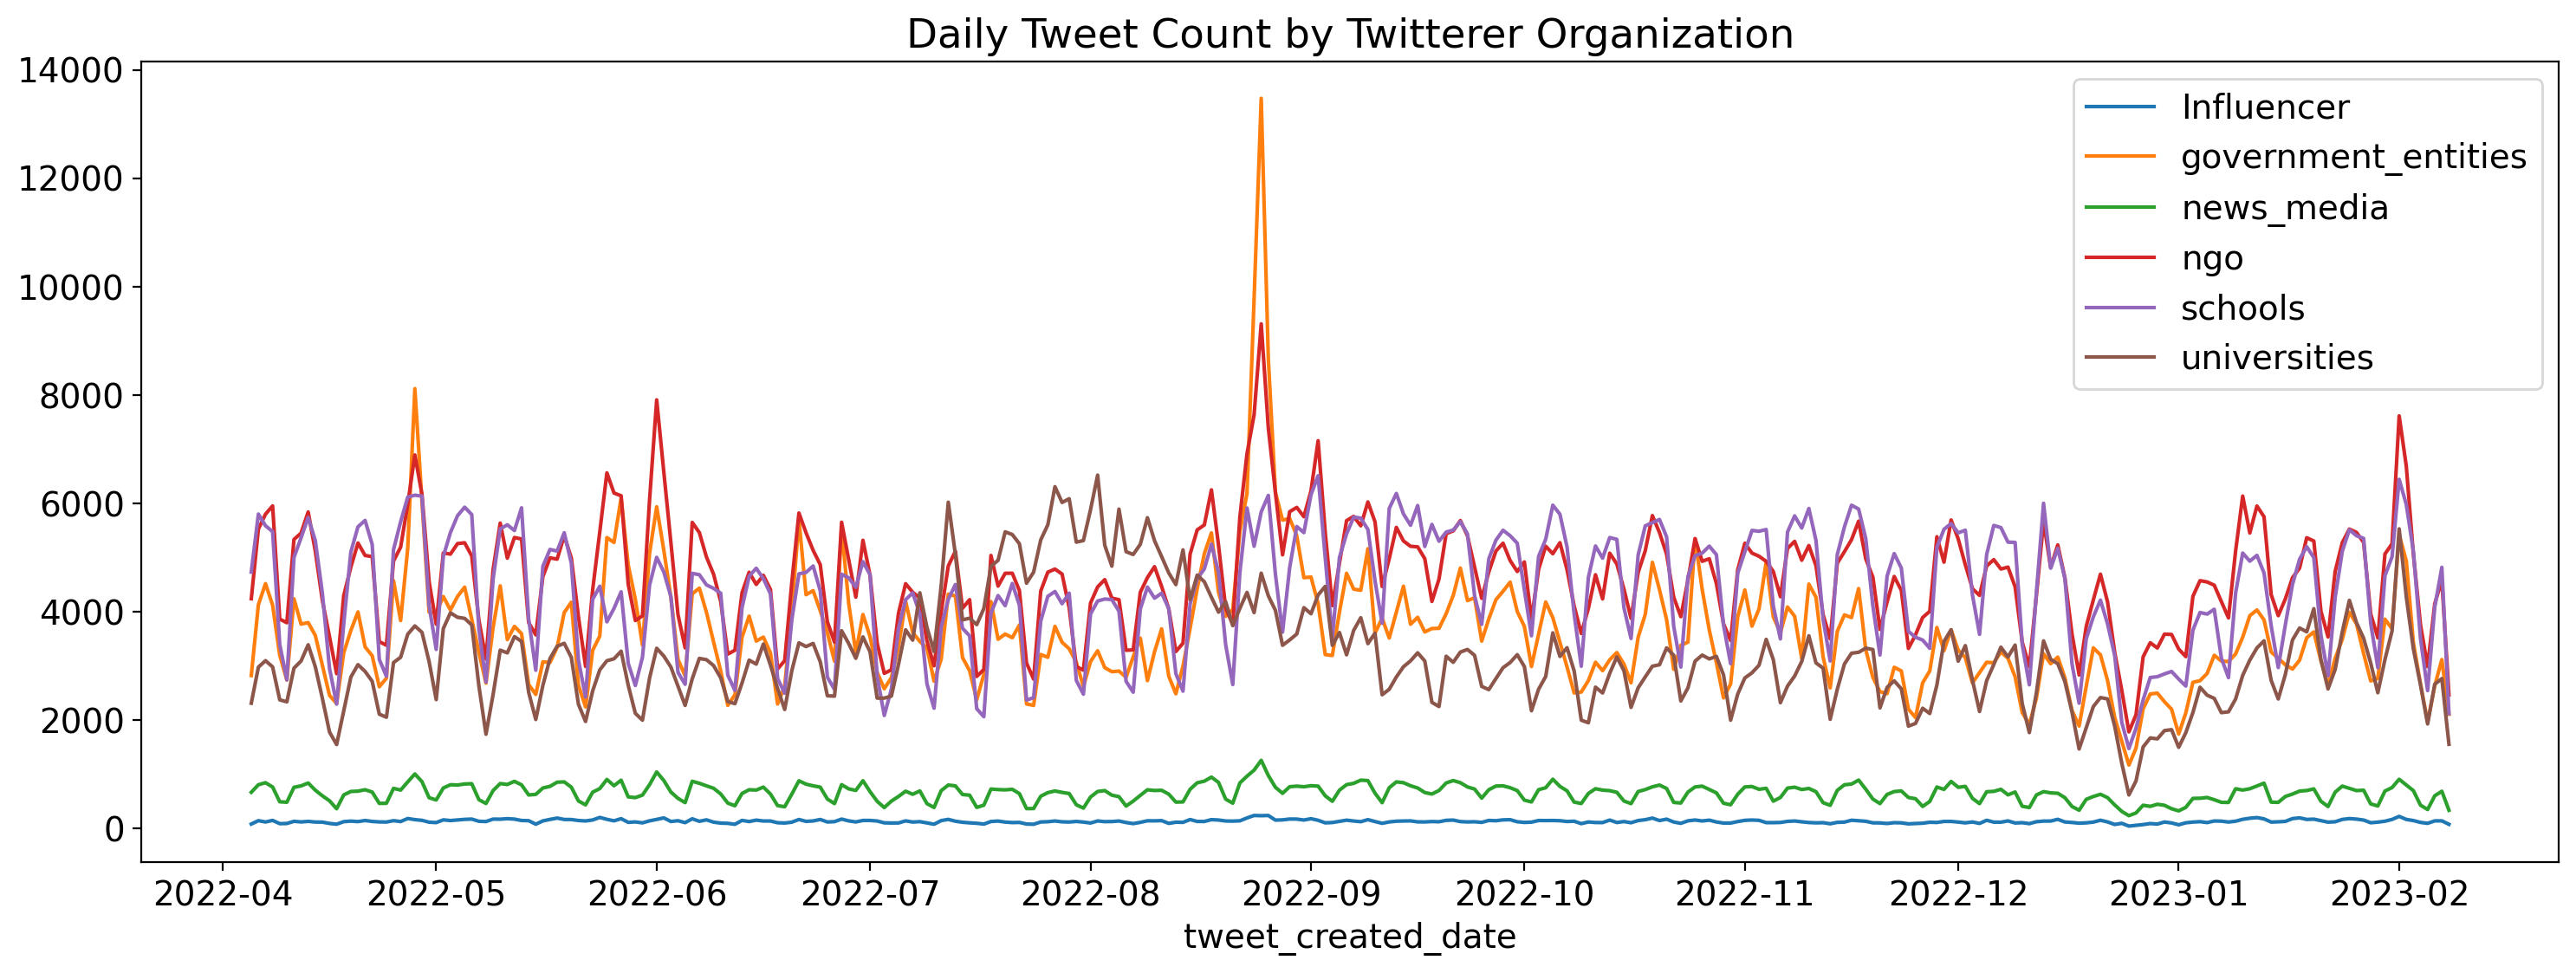

In [37]:
from matplotlib import pyplot as plt 
plt.rcParams.update({'font.size':14})
fig, ax = plt.subplots()
for label, grp in org_time_pd2.groupby('twitterer_catogory'):
    grp.plot(x = 'tweet_created_date', y = 'count',ax = ax, label = label,title='Daily Tweet Count by Twitterer Organization')

In [ ]:
# overall_time_df = time_df.groupBy(['tweet_id', 'tweet_created_date']).count().orderBy('count', ascending=False)

In [ ]:
# org_time_df = org_time_df.select(['tweet_created_date', 'twitterer_catogory']).groupBy('twitterer_catogory', 'tweet_created_date').count()


In [ ]:
# org_time_pd = org_time_pd.toPandas()

In [ ]:
# org_time_pd